<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/master/07-RL/07-practice/PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/qfettes/DeepRL-Tutorials/blob/master/networks/networks.py

https://github.com/openai/baselines

In [0]:
import torch

In [0]:
import gym

In [3]:
!git clone https://github.com/openai/baselines.git

fatal: destination path 'baselines' already exists and is not an empty directory.


In [4]:
!git clone https://github.com/qfettes/DeepRL-Tutorials.git

fatal: destination path 'DeepRL-Tutorials' already exists and is not an empty directory.


In [0]:
import sys
sys.path.append('DeepRL-Tutorials')
sys.path.append('baselines')

In [0]:
import gym
gym.logger.set_level(40)

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

from IPython.display import clear_output
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from datetime import timedelta
import os
import glob


from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

from utils.hyperparameters import Config
from utils.plot import plot
from utils.wrappers import make_env_a2c_atari
from agents.A2C import Model as A2C

In [0]:
log_dir = "/tmp/gym/"

try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv'))
    for f in files:
        os.remove(f)

config = Config()

#ppo control
config.ppo_epoch = 3
config.num_mini_batch = 32
config.ppo_clip_param = 0.1

#a2c control
config.num_agents=8
config.rollout=128
config.USE_GAE = True
config.gae_tau = 0.95

#misc agent variables
config.GAMMA=0.99
config.LR=7e-4
config.entropy_loss_weight=0.01
config.value_loss_weight=1.0
config.grad_norm_max = 0.5

config.MAX_FRAMES=int(1e7 / config.num_agents / config.rollout)

In [0]:
class RolloutStorage(object):
    def __init__(self, num_steps, num_processes, obs_shape, action_space, device, USE_GAE=True, gae_tau=0.95):
        self.observations = torch.zeros(num_steps + 1, num_processes, *obs_shape).to(device)
        self.rewards = torch.zeros(num_steps, num_processes, 1).to(device)
        self.value_preds = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.returns = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.action_log_probs = torch.zeros(num_steps, num_processes, 1).to(device)
        self.actions = torch.zeros(num_steps, num_processes, 1).to(device, torch.long)
        self.masks = torch.ones(num_steps + 1, num_processes, 1).to(device)

        self.num_steps = num_steps
        self.step = 0
        self.gae = USE_GAE
        self.gae_tau = gae_tau

    def insert(self, current_obs, action, action_log_prob, value_pred, reward, mask):
        self.observations[self.step + 1].copy_(current_obs)
        self.actions[self.step].copy_(action)
        self.action_log_probs[self.step].copy_(action_log_prob)
        self.value_preds[self.step].copy_(value_pred)
        self.rewards[self.step].copy_(reward)
        self.masks[self.step + 1].copy_(mask)

        self.step = (self.step + 1) % self.num_steps

    def after_update(self):
        self.observations[0].copy_(self.observations[-1])
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value, gamma):
        if self.gae:
            self.value_preds[-1] = next_value
            gae = 0
            for step in reversed(range(self.rewards.size(0))):
                delta = self.rewards[step] + gamma * self.value_preds[step + 1] * self.masks[step + 1] - self.value_preds[step]
                gae = delta + gamma * self.gae_tau * self.masks[step + 1] * gae
                self.returns[step] = gae + self.value_preds[step]
        else:
            self.returns[-1] = next_value
            for step in reversed(range(self.rewards.size(0))):
                self.returns[step] = self.returns[step + 1] * \
                    gamma * self.masks[step + 1] + self.rewards[step]

    def feed_forward_generator(self, advantages, num_mini_batch):
        num_steps, num_processes = self.rewards.size()[0:2]
        batch_size = num_processes * num_steps
        assert batch_size >= num_mini_batch, (
            f"PPO requires the number processes ({num_processes}) "
            f"* number of steps ({num_steps}) = {num_processes * num_steps} "
            f"to be greater than or equal to the number of PPO mini batches ({num_mini_batch}).")
        mini_batch_size = batch_size // num_mini_batch
        sampler = BatchSampler(SubsetRandomSampler(range(batch_size)), mini_batch_size, drop_last=False)
        for indices in sampler:
            observations_batch = self.observations[:-1].view(-1,
                                        *self.observations.size()[2:])[indices]
            actions_batch = self.actions.view(-1, self.actions.size(-1))[indices]
            return_batch = self.returns[:-1].view(-1, 1)[indices]
            masks_batch = self.masks[:-1].view(-1, 1)[indices]
            old_action_log_probs_batch = self.action_log_probs.view(-1, 1)[indices]
            adv_targ = advantages.view(-1, 1)[indices]

            yield observations_batch, actions_batch, return_batch, masks_batch, old_action_log_probs_batch, adv_targ

In [0]:
class Model(A2C):
    def __init__(self, static_policy=False, env=None, config=None):
        super(Model, self).__init__(static_policy, env, config)
        
        self.num_agents = config.num_agents
        self.value_loss_weight = config.value_loss_weight
        self.entropy_loss_weight = config.entropy_loss_weight
        self.rollout = config.rollout
        self.grad_norm_max = config.grad_norm_max

        self.ppo_epoch = config.ppo_epoch
        self.num_mini_batch = config.num_mini_batch
        self.clip_param = config.ppo_clip_param

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, eps=1e-5)
        
        self.rollouts = RolloutStorage(self.rollout, self.num_agents,
            self.num_feats, self.env.action_space, self.device, config.USE_GAE, config.gae_tau)

    def compute_loss(self, sample):
        observations_batch, actions_batch, return_batch, masks_batch, old_action_log_probs_batch, adv_targ = sample

        values, action_log_probs, dist_entropy = self.evaluate_actions(observations_batch, actions_batch)

        ratio = torch.exp(action_log_probs - old_action_log_probs_batch)
        surr1 = ratio * adv_targ
        surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv_targ
        action_loss = -torch.min(surr1, surr2).mean()

        value_loss = F.mse_loss(return_batch, values)

        loss = action_loss + self.value_loss_weight * value_loss - self.entropy_loss_weight * dist_entropy

        return loss, action_loss, value_loss, dist_entropy

    def update(self, rollout):
        advantages = rollout.returns[:-1] - rollout.value_preds[:-1]
        advantages = (advantages - advantages.mean()) / (
            advantages.std() + 1e-5)


        value_loss_epoch = 0
        action_loss_epoch = 0
        dist_entropy_epoch = 0

        for e in range(self.ppo_epoch):
            data_generator = rollout.feed_forward_generator(
                advantages, self.num_mini_batch)

            for sample in data_generator:
                loss, action_loss, value_loss, dist_entropy = self.compute_loss(sample)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_norm_max)
                self.optimizer.step()

                value_loss_epoch += value_loss.item()
                action_loss_epoch += action_loss.item()
                dist_entropy_epoch += dist_entropy.item()
        
        value_loss_epoch /= (self.ppo_epoch * self.num_mini_batch)
        action_loss_epoch /= (self.ppo_epoch * self.num_mini_batch)
        dist_entropy_epoch /= (self.ppo_epoch * self.num_mini_batch)
        total_loss = value_loss_epoch + action_loss_epoch + dist_entropy_epoch

        #self.save_loss(total_loss, action_loss_epoch, value_loss_epoch, dist_entropy_epoch)

        return action_loss_epoch, value_loss_epoch, dist_entropy_epoch

In [0]:
!rm -rf images
!mkdir -p saved_agents

Updates 9700, Num Timesteps 9933824, FPS 432,
Mean/Median Reward5.5/2.5, Min/Max Reward 0.0/16.0,
Entropy 1.21897, Value Loss -0.01021, Policy Loss 0.13555


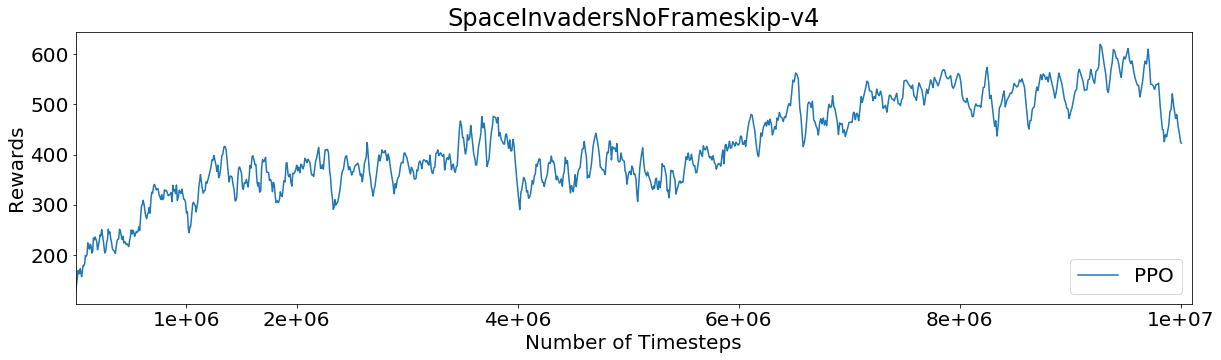

9701|9702|9703|9704|9705|9706|9707|9708|9709|9710|9711|9712|9713|9714|9715|9716|9717|9718|9719|9720|9721|9722|9723|9724|9725|9726|9727|9728|9729|9730|9731|9732|9733|9734|9735|9736|9737|9738|9739|9740|9741|9742|9743|9744|9745|9746|9747|9748|9749|9750|9751|9752|9753|9754|9755|9756|9757|9758|9759|9760|9761|9762|9763|9764|9765|

FileNotFoundError: ignored

In [11]:
if __name__=='__main__':
    seed = 1

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    torch.set_num_threads(1)

    env_id = "SpaceInvadersNoFrameskip-v4"
    envs = [make_env_a2c_atari(env_id, seed, i, log_dir) for i in range(config.num_agents)]
    envs = SubprocVecEnv(envs) if config.num_agents > 1 else DummyVecEnv(envs)

    obs_shape = envs.observation_space.shape
    obs_shape = (obs_shape[0] * 4, *obs_shape[1:])

    model = Model(env=envs, config=config)

    current_obs = torch.zeros(config.num_agents, *obs_shape,
                    device=config.device, dtype=torch.float)

    def update_current_obs(obs):
        shape_dim0 = envs.observation_space.shape[0]
        obs = torch.from_numpy(obs.astype(np.float32)).to(config.device)
        current_obs[:, :-shape_dim0] = current_obs[:, shape_dim0:]
        current_obs[:, -shape_dim0:] = obs

    obs = envs.reset()
    update_current_obs(obs)

    model.rollouts.observations[0].copy_(current_obs)
    
    episode_rewards = np.zeros(config.num_agents, dtype=np.float)
    final_rewards = np.zeros(config.num_agents, dtype=np.float)

    start=timer()

    print_step = 1
    print_threshold = 10
    
    for frame_idx in range(1, config.MAX_FRAMES+1):
        print(frame_idx, end='|')
        for step in range(config.rollout):
            with torch.no_grad():
                values, actions, action_log_prob = model.get_action(model.rollouts.observations[step])
            cpu_actions = actions.view(-1).cpu().numpy()
    
            obs, reward, done, _ = envs.step(cpu_actions)
        
            episode_rewards += reward
            masks = 1. - done.astype(np.float32)
            final_rewards *= masks
            final_rewards += (1. - masks) * episode_rewards
            episode_rewards *= masks

            rewards = torch.from_numpy(reward.astype(np.float32)).view(-1, 1).to(config.device)
            masks = torch.from_numpy(masks).to(config.device).view(-1, 1)

            current_obs *= masks.view(-1, 1, 1, 1)
            update_current_obs(obs)

            model.rollouts.insert(current_obs, actions.view(-1, 1), action_log_prob, values, rewards, masks)
            
            if frame_idx % 10 == 0:
                env_images = envs.get_images()
                for env_number in range(len(env_images)):
                    dir_path = 'images/frame_idx={}/env={}'.format(frame_idx, env_number)
                    os.makedirs(dir_path, exist_ok=True)
                    plt.imsave('{}/step={}.jpg'.format(dir_path, str(step).zfill(3)),
                               env_images[0])
            
        with torch.no_grad():
            next_value = model.get_values(model.rollouts.observations[-1])

        model.rollouts.compute_returns(next_value, config.GAMMA)
            
        value_loss, action_loss, dist_entropy = model.update(model.rollouts)
        
        model.rollouts.after_update()

        if frame_idx % 100 == 0:
            try:
                clear_output()
                end = timer()
                total_num_steps = (frame_idx + 1) * config.num_agents * config.rollout
                print(("Updates {}, Num Timesteps {}, FPS {},\nMean/Median Reward" +
                      "{:.1f}/{:.1f}, Min/Max Reward {:.1f}/{:.1f},\nEntropy {:.5f}, "+
                      "Value Loss {:.5f}, Policy Loss {:.5f}").
                format(frame_idx, total_num_steps,
                       int(total_num_steps / (end - start)),
                       np.mean(final_rewards),
                       np.median(final_rewards),
                       np.min(final_rewards),
                       np.max(final_rewards), dist_entropy,
                       value_loss, action_loss))
                plot(log_dir, "SpaceInvadersNoFrameskip-v4", 'PPO', 
                     config.MAX_FRAMES * config.num_agents * config.rollout)
                
            except IOError:
                pass

    model.save_w()
    envs.close()

In [0]:
!tar czf images.tar.gz images/

In [20]:
!ls -hl images.tar.gz

-rw-r--r-- 1 root root 4.6G May 30 13:32 images.tar.gz


In [24]:
!tar tzf images.tar.gz | head -15

images/
images/frame_idx=650/
images/frame_idx=650/env=6/
images/frame_idx=650/env=6/step=021.jpg
images/frame_idx=650/env=6/step=126.jpg
images/frame_idx=650/env=6/step=094.jpg
images/frame_idx=650/env=6/step=031.jpg
images/frame_idx=650/env=6/step=036.jpg
images/frame_idx=650/env=6/step=064.jpg
images/frame_idx=650/env=6/step=018.jpg
images/frame_idx=650/env=6/step=097.jpg
images/frame_idx=650/env=6/step=063.jpg
images/frame_idx=650/env=6/step=103.jpg
images/frame_idx=650/env=6/step=086.jpg
images/frame_idx=650/env=6/step=016.jpg
